# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [99]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', None)

%matplotlib notebook

In [100]:
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv',
                parse_dates = ['Date'],
                index_col = ['Date'])

df['Year'] = pd.DatetimeIndex(df.index).year
df['Month'] = pd.DatetimeIndex(df.index).month
df['Day'] = pd.DatetimeIndex(df.index).day
#df['Month_Year'] = pd.to_datetime(df.index).to_period('M')

df['Data_Value'] = df['Data_Value'] * 0.1 #According to the instructions values are in tenths of a degree C

print (df.dtypes)
print (df.shape)
df.head()

ID             object
Element        object
Data_Value    float64
Year            int32
Month           int32
Day             int32
dtype: object
(165085, 6)


,ID,Element,Data_Value,Year,Month,Day
Date,,,,,,
2014-11-12,USW00094889,TMAX,2.2,2014,11,12
2009-04-29,USC00208972,TMIN,5.6,2009,4,29
2008-05-26,USC00200032,TMAX,27.8,2008,5,26
2005-11-11,USC00205563,TMAX,13.9,2005,11,11
2014-02-27,USC00200230,TMAX,-10.6,2014,2,27


In [101]:
df = df.drop(['2005-02-29', '2006-02-29', '2007-02-29',
        '2008-02-29', '2009-02-29', '2010-02-29', 
        '2011-02-29', '2012-02-29', '2013-02-29',
        '2014-02-29', '2015-02-29', '2016-02-29']) # Removes leap years
df = df.reset_index()
df['DOY'] = df['Date'].dt.dayofyear

df.head()

,Date,ID,Element,Data_Value,Year,Month,Day,DOY
0,2014-11-12,USW00094889,TMAX,2.2,2014,11,12,316
1,2009-04-29,USC00208972,TMIN,5.6,2009,4,29,119
2,2008-05-26,USC00200032,TMAX,27.8,2008,5,26,147
3,2005-11-11,USC00205563,TMAX,13.9,2005,11,11,315
4,2014-02-27,USC00200230,TMAX,-10.6,2014,2,27,58


In [111]:
#------------------ general data cleaning -------------------
df_max = df[(df['Element'] == 'TMAX') & (df['Year'] != 2015)]
df_min = df[(df['Element'] == 'TMIN') & (df['Year'] != 2015)]
df_2015 = df[df['Year'] == 2015].reset_index()
#df_2015

df_max = df_max.groupby('DOY').max()
df_max.rename(columns = {'Data_Value': 'Max'}, inplace = True)
df_min = df_min.groupby('DOY').min()
df_min.rename(columns = {'Data_Value': 'Min'}, inplace = True)
# df_max = df_max.groupby(['Month', 'Day']).mean().reset_index()
# df_min = df_min.groupby(['Month', 'Day']).mean().reset_index()

df_2015.rename(columns = {'Data_Value': 'Temperature'}, inplace = True)
df_2015['2015_Max'] = df_2015['Temperature'].loc[df_2015['Element'] == 'TMAX']
df_2015['2015_Min'] = df_2015['Temperature'].loc[df_2015['Element'] == 'TMIN']

df_2015max = df_2015[['DOY', '2015_Max']]
df_2015min = df_2015[['DOY', '2015_Min']]

df_2015max = df_2015max.groupby('DOY').max()
df_2015min = df_2015min.groupby('DOY').min()

minimum = df_min['Min']
df_final = df_max.join(minimum)
df_final.index.name = 'DOY'

df_final = pd.merge(df_final, df_2015max, left_index = True, right_index = True)
df_final = pd.merge(df_final, df_2015min, left_index = True, right_index = True)
df_final

df_final = df_final[['Max', 'Min', '2015_Max', '2015_Min']]
df_final

# print (df_final.dtypes)
# print (df_final.shape)
# df_final.head()

,Max,Min,2015_Max,2015_Min
DOY,,,,
1,15.6,-16.0,1.1,-13.3
2,13.9,-26.7,3.9,-12.2
3,13.3,-26.7,3.9,-6.7
4,10.6,-26.1,4.4,-8.8
5,12.8,-15.0,2.8,-15.5
6,18.9,-26.6,3.3,-18.2
7,21.7,-30.6,-6.7,-18.2
8,19.4,-29.4,-8.2,-21.1
9,17.8,-27.8,-6.6,-20.6


In [112]:
#if a value in 2015 is greater than the mean of values for 2006-2014, 
#keep it. Otherwise, fill row with 'not a number'

df_final['2015_Max'] = np.where((df_final['2015_Max'] < df_final['Max']),
                               np.nan, df_final['2015_Max'])

df_final['2015_Min'] = np.where((df_final['2015_Min'] > df_final['Min']),
                               np.nan, df_final['2015_Min'])

df_final

,Max,Min,2015_Max,2015_Min
DOY,,,,
1,15.6,-16.0,NaN,NaN
2,13.9,-26.7,NaN,NaN
3,13.3,-26.7,NaN,NaN
4,10.6,-26.1,NaN,NaN
5,12.8,-15.0,NaN,-15.5
6,18.9,-26.6,NaN,NaN
7,21.7,-30.6,NaN,NaN
8,19.4,-29.4,NaN,NaN
9,17.8,-27.8,NaN,NaN


In [113]:
df_final.count() #counts all non NaN values

Max         365
Min         365
2015_Max     43
2015_Min     37
dtype: int64

<IPython.core.display.Javascript object>


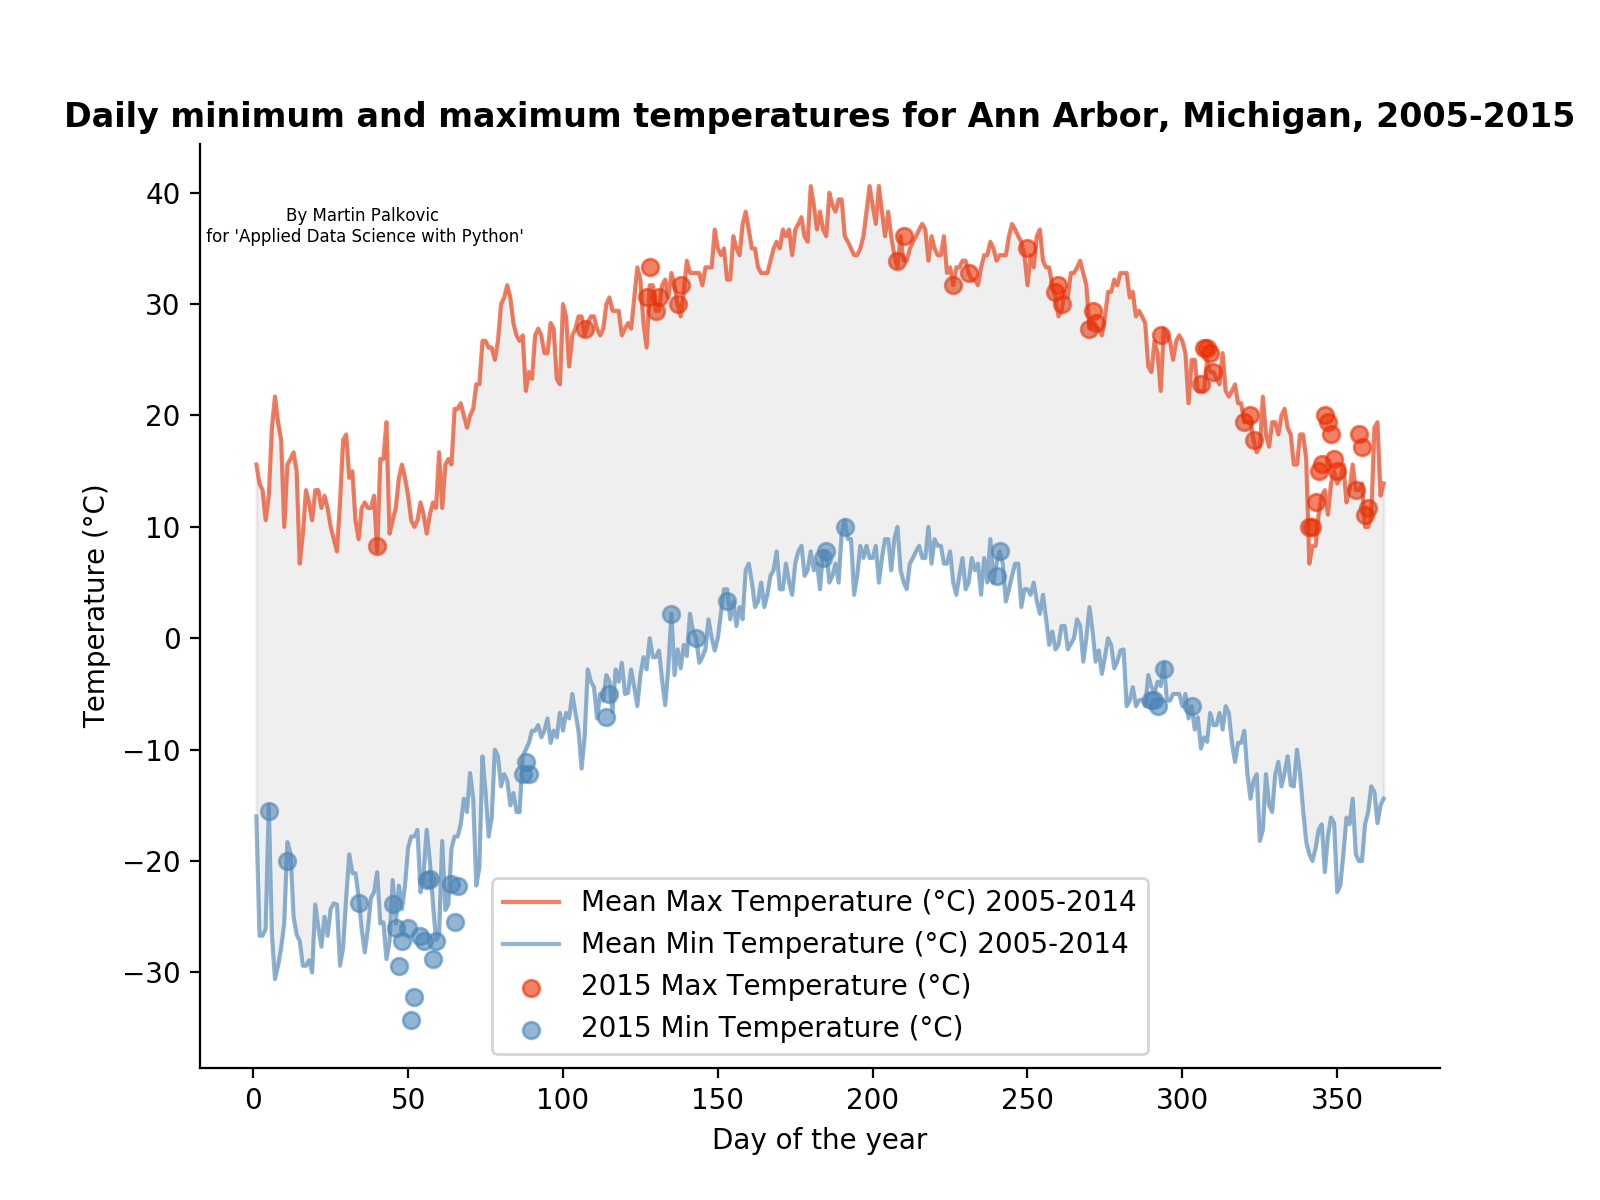

In [119]:
#---- plot it up brah ----
x1 = df_final.index.values
y1 = df_final['Max']
y2 = df_final['Min']
y3 = df_final['2015_Max']
y4 = df_final['2015_Min']

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(x1, y1, color = '#ec2d01', alpha = 0.6)
ax.plot(x1, y2, color = '#4984b8', alpha = 0.6)
ax.scatter(x3, y3, color = '#ec2d01', alpha = 0.6)
ax.scatter(x3, y4, color = '#4984b8', alpha = 0.6)
ax.set_xlabel('Day of the year')
ax.set_ylabel('Temperature (\N{DEGREE SIGN}C)')
ax.set_title('Daily minimum and maximum temperatures for Ann Arbor, Michigan, 2005-2015', weight = 'bold')
ax.legend(['Mean Max Temperature (\N{DEGREE SIGN}C) 2005-2014', 'Mean Min Temperature (\N{DEGREE SIGN}C) 2005-2014',
          '2015 Max Temperature (\N{DEGREE SIGN}C)', '2015 Min Temperature (\N{DEGREE SIGN}C)'])

ax.fill_between(x1, y1, y2, color = '#929591', alpha = 0.15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.annotate('By Martin Palkovic \n for \'Applied Data Science with Python\' ',
           xy = (36, 37),
           fontsize = 6,
           ha = 'center',
           va = 'center')

#fig.savefig('Assignment2.png')

In [29]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')